# Black Hole Spectra

Black hole spectra can be generated by combining a `BlackHoles` object with an ``EmissionModel``, translating the physical properties of the blackhole(s) (e.g. `mass`, `accretion_rate`, etc.) to a spectral energy distribution.

These models are described in detail in the [emission model docs](../emission_models/emission_models.rst). Here, we'll use an instance of a ``UnifiedAGN`` model for demonstration purposes.

The following sections demonstrate the generation of combined spectra (which is the same for both parametric and particle ``BlackHoles``) and per--particle spectra. 

In [1]:
import numpy as np
from unyt import K, Msun, deg, yr

from synthesizer import Grid
from synthesizer.emission_models import (
    AttenuatedEmission,
    DustEmission,
    UnifiedAGN,
)
from synthesizer.emission_models.attenuation import PowerLaw
from synthesizer.emission_models.dust.emission import Greybody
from synthesizer.parametric import BlackHole

# Get the NLR and BLR grids
nlr_grid = Grid("test_grid_agn-nlr", grid_dir="../../../tests/test_grid")
blr_grid = Grid("test_grid_agn-blr", grid_dir="../../../tests/test_grid")

uniagn = UnifiedAGN(
    nlr_grid,
    blr_grid,
    covering_fraction_nlr=0.1,
    covering_fraction_blr=0.1,
    torus_emission_model=Greybody(1000 * K, 1.5),
)

blackhole = BlackHole(
    mass=1e8 * Msun,
    inclination=60 * deg,
    accretion_rate=1 * Msun / yr,
    metallicity=0.01,
)


## Integrated spectra

To generate integrated spectra we simply call the component's ``get_spectra`` method. This method will populate the component's ``spectra`` attribute with a dictionary containing [Sed objects](../sed/sed.rst) for each spectra in the ``EmissionModel``.
It will also return the spectra at the root of the ``EmissionModel``.

/opt/hostedtoolcache/Python/3.10.15/x64/lib/python3.10/site-packages/unyt/array.py:1824: RuntimeWarning: overflow encountered in exp
  out_arr = func(np.asarray(inp), out=out_func, **kwargs)
/opt/hostedtoolcache/Python/3.10.15/x64/lib/python3.10/site-packages/unyt/array.py:1949: RuntimeWarning: overflow encountered in multiply
  out_arr = func(


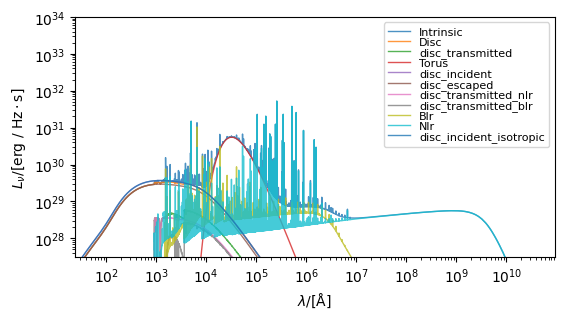

In [2]:
# Get the spectra using a unified agn model (instantiated elsewhere)
spectra = blackhole.get_spectra(uniagn)

fig, ax = blackhole.plot_spectra(
    show=True, ylimits=(10**27.5, 10**34.0), figsize=(6, 4)
)

### Including dust attenuation

We can also generate spectra including attenuation and emission from diffuse dust along the line of sight to the black hole.
We do this by combining the ``UnifiedAGN`` model with models defining these attenuation and emission contributions.

First we define the emission models (for more details see the [emission model docs](../emission_models/custom_models.ipynb)).

In [3]:
tau_v = 0.5
dust_curve = PowerLaw(slope=-1.0)
dust_emission_model = Greybody(30 * K, 1.2)

# Define an emission model to attenuate the intrinsic AGN emission
att_model = AttenuatedEmission(
    dust_curve=dust_curve,
    apply_dust_to=uniagn,
    tau_v=tau_v,
    emitter="blackhole",
)

# And now include the dust emission
dust_model = DustEmission(
    dust_emission_model=dust_emission_model,
    dust_lum_intrinsic=uniagn,
    dust_lum_attenuated=att_model,
    emitter="blackhole",
)

We then follow the same process of calling ``get_spectra`` with the new model.
The plot here shows luminosity rather than spectral energy density.

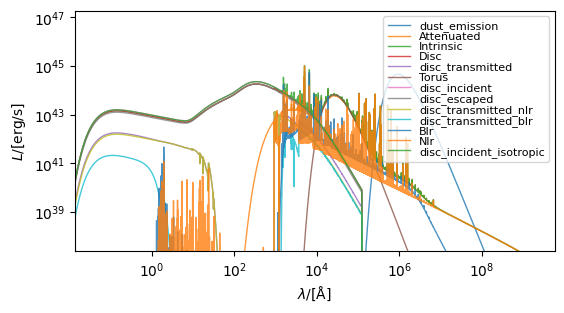

In [4]:
spectra = blackhole.get_spectra(dust_model)

fig, ax = blackhole.plot_spectra(quantity_to_plot="luminosity", figsize=(6, 4))

The spectra returned by ``get_spectra`` is the "dust_emission" spectra at the root of the emission model.

In [5]:
print(spectra)

+-------------------------------------------------------------------------------+
|                                      SED                                      |
+-------------+-----------------------------------------------------------------+
| Attribute   | Value                                                           |
+-------------+-----------------------------------------------------------------+
| redshift    | 0                                                               |
+-------------+-----------------------------------------------------------------+
| lam (9244,) | 1.30e-04 Å -> 2.99e+11 Å (Mean: 9.73e+09 Å)                     |
+-------------+-----------------------------------------------------------------+
| nu (9244,)  | 1.00e+07 Hz -> 2.31e+22 Hz (Mean: 8.51e+19 Hz)                  |
+-------------+-----------------------------------------------------------------+
| lnu (9244,) | 0.00e+00 erg/(Hz*s) -> 1.60e+32 erg/(Hz*s) (Mean: 6.82e+30 erg) |
+-------------+-

However, all the spectra are stored within a dictionary under the ``spectra`` attribute.

In [6]:
print(blackhole.spectra)

{'disc_incident_isotropic': <synthesizer.sed.Sed object at 0x7f92bca62e00>, 'nlr': <synthesizer.sed.Sed object at 0x7f92bc758730>, 'blr': <synthesizer.sed.Sed object at 0x7f92525295a0>, 'disc_transmitted_blr': <synthesizer.sed.Sed object at 0x7f9264536fb0>, 'disc_transmitted_nlr': <synthesizer.sed.Sed object at 0x7f925e55a170>, 'disc_escaped': <synthesizer.sed.Sed object at 0x7f92bca62ec0>, 'disc_incident': <synthesizer.sed.Sed object at 0x7f925252b250>, 'torus': <synthesizer.sed.Sed object at 0x7f92bca63070>, 'disc_transmitted': <synthesizer.sed.Sed object at 0x7f92585bc880>, 'disc': <synthesizer.sed.Sed object at 0x7f92bca63580>, 'intrinsic': <synthesizer.sed.Sed object at 0x7f92585bd120>, 'attenuated': <synthesizer.sed.Sed object at 0x7f92585bcb50>, 'dust_emission': <synthesizer.sed.Sed object at 0x7f92585bcd00>}


## Particle spectra

To demonstrate the particle spectra functionality we first generate some mock particle black hole data, and initialise a ``BlackHoles`` object.

In [7]:
from synthesizer.particle import BlackHoles

# Make fake properties
n = 4
masses = 10 ** np.random.uniform(low=7, high=9, size=n)  # Msun
coordinates = np.random.normal(0, 1.5, (n, 3))  # cMpc
accretion_rates = 10 ** np.random.uniform(
    low=-2, high=1, size=n
)  # Msun  # Msun / yr
metallicities = np.full(n, 0.01)

# And get the black holes object
blackholes = BlackHoles(
    masses=masses,
    coordinates=coordinates,
    accretion_rates=accretion_rates,
    metallicities=metallicities,
)

To generate a spectra for each black hole (per particle) we use the same emission model, but we need to tell the model to produce a spectrum for each particle. This is done by setting the ``per_particle`` flag to ``True`` on the model.

In [8]:
dust_model.set_per_particle(True)

With that done we just call the same ``get_spectra`` method on the component, and the particle spectra will be stored in the ``particle_spectra`` attribute of the component.

In [9]:
spectra = blackholes.get_spectra(dust_model, verbose=True)

Again, the returned spectra is the "dust_emission" spectra from the root of the model.

In [10]:
print(spectra)

+---------------------------------------------------------------------------------+
|                                       SED                                       |
+---------------+-----------------------------------------------------------------+
| Attribute     | Value                                                           |
+---------------+-----------------------------------------------------------------+
| redshift      | 0                                                               |
+---------------+-----------------------------------------------------------------+
| lam (9244,)   | 1.30e-04 Å -> 2.99e+11 Å (Mean: 9.73e+09 Å)                     |
+---------------+-----------------------------------------------------------------+
| nu (9244,)    | 1.00e+07 Hz -> 2.31e+22 Hz (Mean: 8.51e+19 Hz)                  |
+---------------+-----------------------------------------------------------------+
| lnu (4, 9244) | 0.00e+00 erg/(Hz*s) -> 4.72e+31 erg/(Hz*s) (Mean: 1.75e+30

While the spectra produced by ``get_particle_spectra`` are stored in a dictionary under the ``particle_spectra`` attribute.

In [11]:
print(blackholes.particle_spectra)

{'disc_incident_isotropic': <synthesizer.sed.Sed object at 0x7f9246597d30>, 'nlr': <synthesizer.sed.Sed object at 0x7f925e57df00>, 'blr': <synthesizer.sed.Sed object at 0x7f9264534520>, 'disc_transmitted_blr': <synthesizer.sed.Sed object at 0x7f92585bd0c0>, 'disc_transmitted_nlr': <synthesizer.sed.Sed object at 0x7f92585bcb20>, 'disc_escaped': <synthesizer.sed.Sed object at 0x7f9246597760>, 'disc_incident': <synthesizer.sed.Sed object at 0x7f925252b8e0>, 'torus': <synthesizer.sed.Sed object at 0x7f92465952d0>, 'disc_transmitted': <synthesizer.sed.Sed object at 0x7f9246595f00>, 'disc': <synthesizer.sed.Sed object at 0x7f9246525570>, 'intrinsic': <synthesizer.sed.Sed object at 0x7f9246524fa0>, 'attenuated': <synthesizer.sed.Sed object at 0x7f9246525630>, 'dust_emission': <synthesizer.sed.Sed object at 0x7f9246524d60>}


### Integrating spectra

The integrated spectra are automatically produced alongside per particle spectra. However, if we wanted to explictly get the integrated spectra from the particle spectra we just generated (for instance if we had made some modification after generation), we can call the ``integrate_particle_spectra`` method. This method will sum the individual spectra and populate the ``spectra`` dictionary.

Note, we can also integrate individual spectra using the ``Sed.sum()`` method.

{'disc_incident_isotropic': <synthesizer.sed.Sed object at 0x7f925e57dea0>, 'nlr': <synthesizer.sed.Sed object at 0x7f92585bcdc0>, 'blr': <synthesizer.sed.Sed object at 0x7f9264536f50>, 'disc_transmitted_blr': <synthesizer.sed.Sed object at 0x7f92585bcdf0>, 'disc_transmitted_nlr': <synthesizer.sed.Sed object at 0x7f9246597a90>, 'disc_escaped': <synthesizer.sed.Sed object at 0x7f92465973d0>, 'disc_incident': <synthesizer.sed.Sed object at 0x7f9246597e20>, 'torus': <synthesizer.sed.Sed object at 0x7f925252b310>, 'disc_transmitted': <synthesizer.sed.Sed object at 0x7f92525292d0>, 'disc': <synthesizer.sed.Sed object at 0x7f9246525390>, 'intrinsic': <synthesizer.sed.Sed object at 0x7f9246524be0>, 'attenuated': <synthesizer.sed.Sed object at 0x7f9246524460>, 'dust_emission': <synthesizer.sed.Sed object at 0x7f9246524dc0>}
{'disc_incident_isotropic': <synthesizer.sed.Sed object at 0x7f925257ece0>, 'nlr': <synthesizer.sed.Sed object at 0x7f9264537b50>, 'blr': <synthesizer.sed.Sed object at 0x7

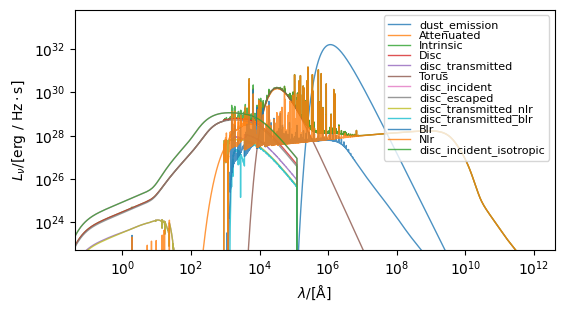

In [12]:
print(blackholes.spectra)
blackholes.integrate_particle_spectra()
print(blackholes.spectra)

fig, ax = blackholes.plot_spectra(show=True, figsize=(6, 4))

## Modifying `EmissionModel` parameters with `get_spectra`

As well as modifying a model explicitly, it's also possible to overide the properties of a model at the point `get_spectra` is called. These modifications will not be remembered by the model afterwards. As it stands, this form of modification is supported for the `dust_curve`, `tau_v`, `covering_fraction` and `masks`.

Here we'll demonstrate this by overiding the covering fractions to generate spectra for a range of `covering_fraction` values. This can either be done by passing a single number which will overide all covering fractions on every model (probably undesirable behaviour since this will set NLR and BLR covering fractions to be equal).

In [13]:
# Since we now want integrated spectra lets remove the per particle flag
dust_model.set_per_particle(False)

blackhole.clear_all_spectra()
spectra = {}
for fesc in [0.1, 0.5, 0.9]:
    blackhole.get_spectra(dust_model, covering_fraction=fesc)
    spectra[r"$f " f"=$ {fesc}"] = blackhole.spectra["intrinsic"]

Or (more desirably) we can pass a dictionary mapping model labels to `fesc` values to target specific models. Notice that we have invoked the `clear_all_spectra` method to reset the spectra dictionary, we can also clear all emissions (including spectra, lines, and photometry if they are present) with the `clear_all_emissions` method.

In [14]:
blackhole.clear_all_emissions()
spectra = {}
for nlr_fesc in [0.1, 0.5, 0.9]:
    for blr_fesc in [0.1, 0.5, 0.9]:
        blackhole.get_spectra(
            dust_model,
            covering_fraction={
                "disc_transmitted_nlr": nlr_fesc,
                "disc_transmitted_blr": blr_fesc,
            },
        )
        spectra[
            r"$f_\mathrm{nlr} "
            f"=$ {nlr_fesc}, "
            r"$f_\mathrm{blr} "
            f"=$ {blr_fesc},"
        ] = blackhole.spectra["intrinsic"]

To see the variation above we can pass the dictionary we populated with the varied spectra to the `plot_spectra` function (where the dictionary keys will be used as labels). 


(<Figure size 800x400 with 1 Axes>,
 <Axes: xlabel='$\\lambda/[\\mathrm{\\AA}]$', ylabel='$L_{\\nu}/[\\mathrm{\\rm{erg} \\ / \\ \\rm{Hz \\cdot \\rm{s}}}]$'>)

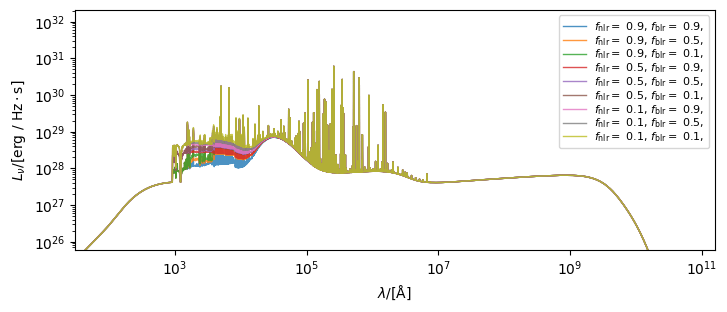

In [15]:
from synthesizer.sed import plot_spectra

plot_spectra(spectra, figsize=(8, 4))